# Tourism Exploratory Data Analysis and Feature Engineering

In [1]:
import IPython.display as disp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling
import pycountry
import seaborn as sns
from scipy.stats import boxcox, kurtosis, kurtosistest, skew, skewtest
from sklearn import preprocessing
from sklearn.decomposition import PCA, FactorAnalysis

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df = pd.read_pickle("../data/interim/Tourism2.pickle").set_index(
    ['Country Code', 'Year'])

m = df.mean()
m.name = "Mean"
md = df.median()
md.name = "Median"

## Descriptive Statistics

| Variable          | Name                                                                             |
|-------------------|----------------------------------------------------------------------------------|
| ST.INT.ARVL       | International tourism, number of arrivals                                        |
| ST.INT.RCPT.CD    | International tourism, receipts (current US\$)                                   |
| ST.INT.TVLR.CD    | International tourism, receipts for passenger transport items (current US\$)     |
| ST.INT.TRNR.CD    | International tourism, receipts for travel items (current US\$)                  |
| ST.INT.DPRT       | International tourism, expenditures (current US\$)                               |
| ST.INT.XPND.CD    | International tourism, expenditures for passenger transport items (current US\$) |
| ST.INT.TVLX.CD    | International tourism, expenditures for travel items (current US\$)              |
| ST.INT.TRNX.CD    | International tourism, number of departures                                      |
| ST.INT.RCPT.XP.ZS | International tourism, receipts (\% of total exports)                            |
| ST.INT.XPND.MP.ZS | International tourism, expenditures (% of total imports)                         |

### Central Tendency
| {{ m.to_frame() }} | {{ md.to_frame() }} |  |
|--------------------------------------------------------------|---------------------------------------------------------------------|---|

### Variance and Ranges
{{ df.describe().transpose()[['std','min','max']].rename(index=str, columns={"std":"Standard Deviation","min":"Minimum Value","max":"Maximum Value"}) }}

### Skewness

In [2]:
# calculate skews of variables
skews = []
for var_name in df.columns:
    variable = df[var_name][(df[var_name].notna())].tolist()
    s = skew(variable)
    zscore, pvalue = skewtest(variable)
    skews.append({
        'variable': var_name,
        'skewness': s,
        'z-score': zscore,
        'p-value': pvalue,
        'normal': (pvalue >= .05)
    })
skew_df = pd.DataFrame(
    skews, columns=['variable', 'normal', 'skewness', 'z-score', 'p-value'])

H<sub>0</sub>: Variable sample has skew of the normal distribution (p ≥ .05)

H<sub>a</sub>: Variable does not have the skew of the normal distribution

{{ skew_df }}

### Kurtosis

In [3]:
# calculate kurtosis of variables
kurt = []
for var_name in df.columns:
    variable = df[var_name][(df[var_name].notna())].tolist()
    k = kurtosis(variable)
    zscore, pvalue = kurtosistest(variable)
    kurt.append({
        'variable': var_name,
        'kurtosis': k,
        'z-score': zscore,
        'p-value': pvalue,
        'normal': (pvalue >= .05)
    })
kurt_df = pd.DataFrame(
    kurt, columns=['variable', 'normal', 'kurtosis', 'z-score', 'p-value'])

H<sub>0</sub>: Variable sample has kurtosis of the normal distribution (p ≥ .05)

H<sub>a</sub>: Variable does not have the kurtosis of the normal distribution

 
{{ kurt_df }}

### Quartiles
{{ df.describe().transpose()[["min","25%","50%","75%","max"]] }}

## EDA & Reduction

### Correlation Matrix Heatmap

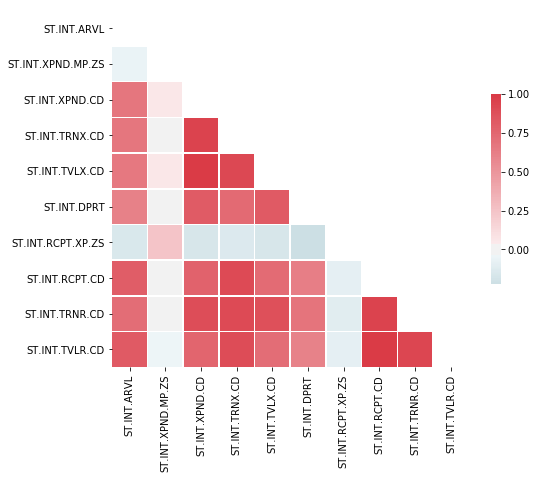

In [4]:
""" Plot a (non-square) correlation heatmap
"""
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 7))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr,
            mask=mask,
            cmap=cmap,
            vmax=1,
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5})

### Data Profile Report

In [5]:
profile = pandas_profiling.ProfileReport(df)
profile.to_file("../docs/profile.html")

### Highly correlated variables
Anything with `ρ ≥ .9` could end up skewing the calculations.

In [6]:
profile.description_set['correlations']['pearson'][
    profile.get_rejected_variables(.9)]

,ST.INT.RCPT.CD,ST.INT.TRNR.CD,ST.INT.TRNX.CD,ST.INT.TVLR.CD,ST.INT.TVLX.CD
Year,0.125,0.083,0.061,0.120,0.111
ST.INT.ARVL,0.805,0.722,0.678,0.824,0.660
ST.INT.XPND.MP.ZS,-0.031,-0.008,0.028,-0.035,0.062
ST.INT.XPND.CD,0.777,0.893,0.944,0.765,0.993
ST.INT.TRNX.CD,0.909,0.913,1.000,0.897,0.916
ST.INT.TVLX.CD,0.726,0.875,0.916,0.719,1.000
ST.INT.DPRT,0.623,0.684,0.738,0.608,0.821
ST.INT.RCPT.XP.ZS,-0.090,-0.109,-0.138,-0.084,-0.167
ST.INT.RCPT.CD,1.000,0.952,0.909,0.996,0.726
ST.INT.TRNR.CD,0.952,1.000,0.913,0.929,0.875


- ST.INT.TVLR.CD with ST.INT.TRNR.CD (ρ = 0.9294)
  - Receipts for travel items in country
  
  - Receipts for passenger transport items in country
  
 > 93% of tourism travel receipts are from passenger transport

- ST.INT.TRNR.CD with ST.INT.RCPT.CD (ρ = 0.952)
  - Receipts for passenger transport items in country
  
  - Receipts for tourism in country
  
 > Passenger transport makes up 95.2% of export tourism

- ST.INT.RCPT.CD with ST.INT.TRNX.CD (ρ = 0.90905)
  - Receipts for tourism in country
  
  - Expenditures for passenger transport items abroad

 > Total tourism income and passenger transport abroad are highly correlated.

- ST.INT.TVLX.CD with ST.INT.TRNX.CD (ρ = 0.91601)
  - Expenditures for travel items abroad

  - Expenditures for passenger transport items abroad
  
  > 92% of tourism travel expenditures are from passenger transport

- ST.INT.TRNX.CD with ST.INT.XPND.CD (ρ = 0.94419)
  - Expenditures for passenger transport items abroad
  
  - Expenditures for tourism abroad

 > Passenger transport makes up 94.42% of import tourism
 
 #### Summary:
 
 - About 95% of tourism spending is on transportation. This is interesting, but for comparison analysis, these variables will skew the models and not provide much more insight.


In [7]:
df_small = df.drop([
    'ST.INT.TRNX.CD', 'ST.INT.TVLX.CD', 'ST.INT.TRNX.CD', 'ST.INT.TRNR.CD',
    'ST.INT.TVLR.CD'
],
    axis="columns")

### Remaining Variables
5 of the 11 original variables were dropped due to high correlation.
The rest are in the pair plot below.

/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


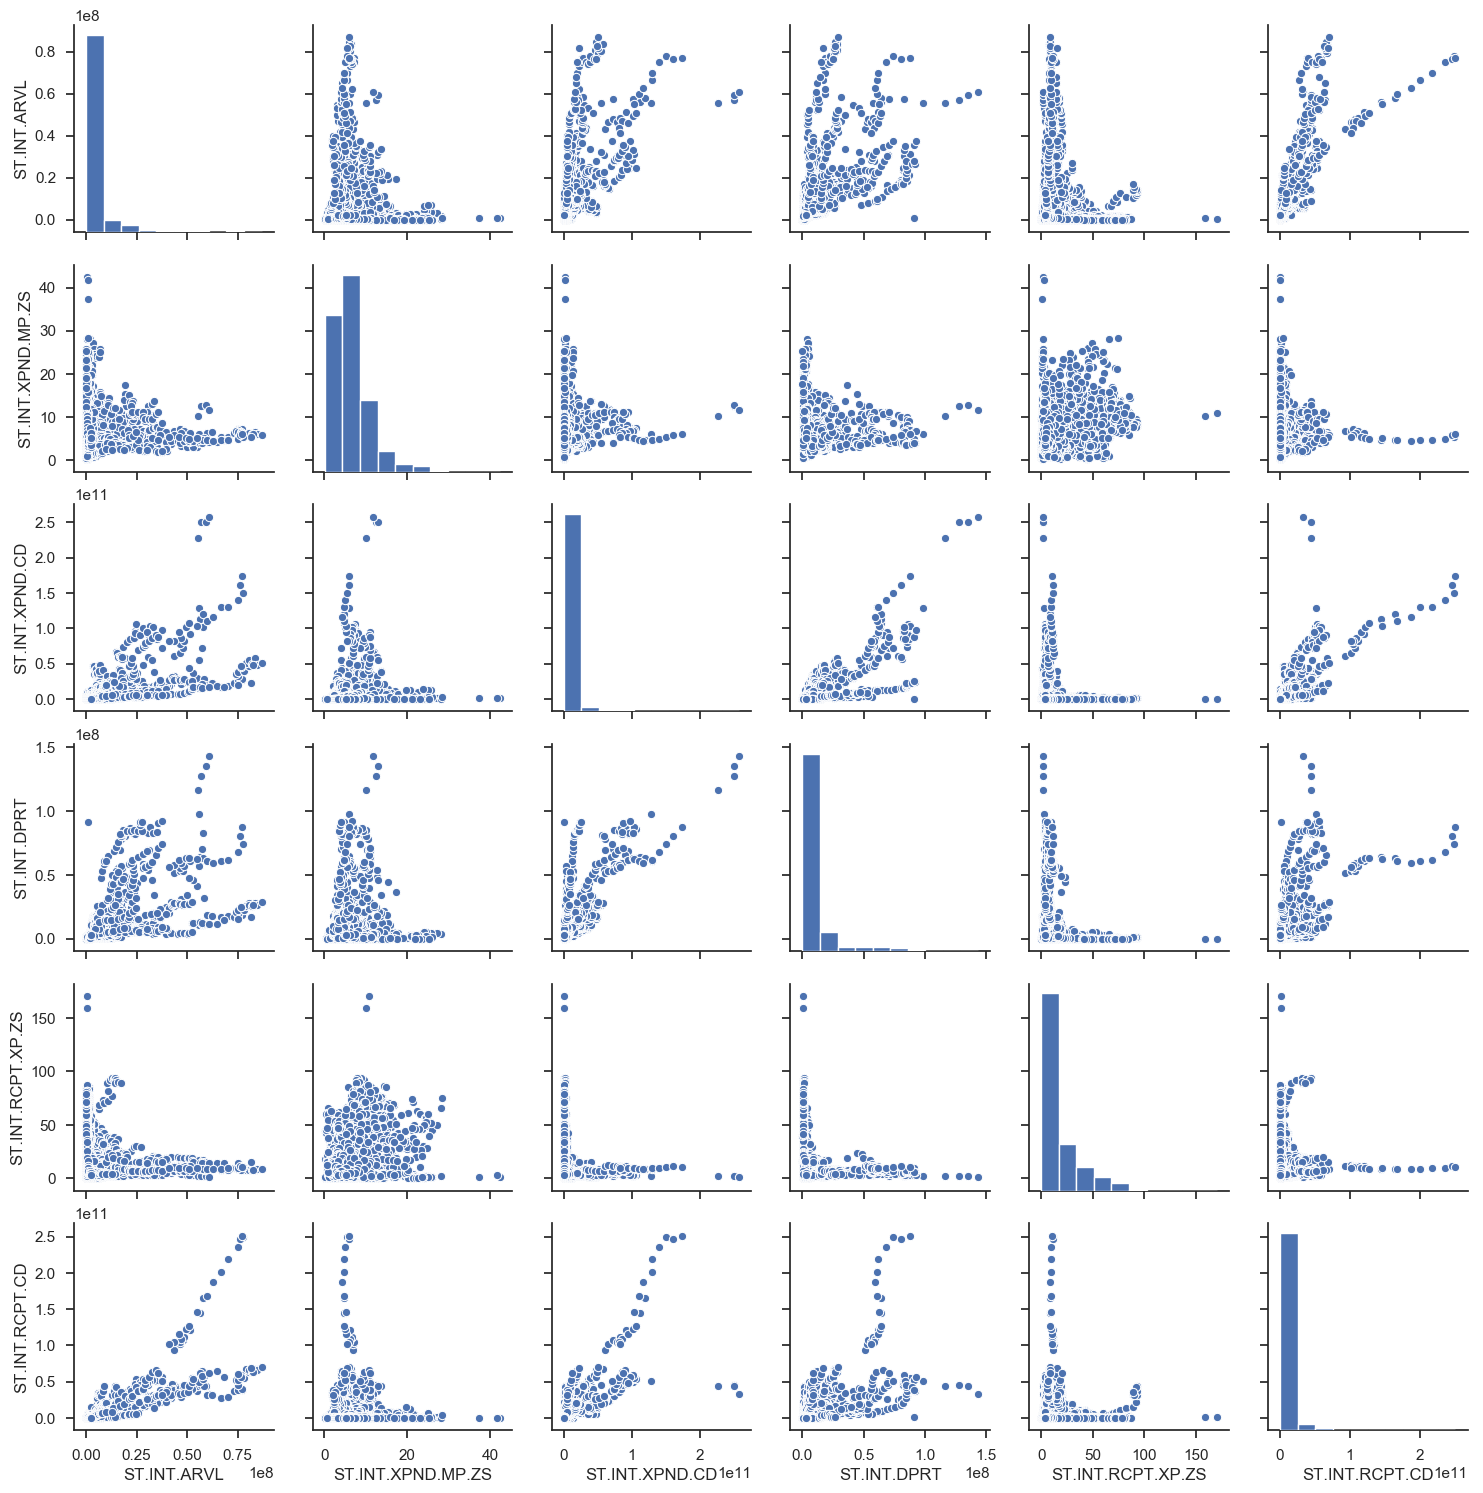

In [8]:
sns.set(style="ticks")
sns.pairplot(df_small)  # ¯\_(ツ)_/¯

## Pair-plot analysis

There are some interesting visual relationships in the pair plot above.

#### Relationships with International Arrivals (ST.INT.ARVL)
- International tourism receipts (ST.INT.RCPT.XP.ZS & ST.INT.RCPT.CD)
  - Two disparate coefficients
- International departures (ST.INT.DPRT)
  - 3-5 disparate coefficients

## Feature Construction

In [9]:
""" Tourist defecit (# More arrivals than departures)  
"""
df_small["Tourist Defecit"] = df_small["ST.INT.ARVL"] - df_small["ST.INT.DPRT"]

In [10]:
""" Tourist net ($ More exports than imports)  
"""
df_small["Tourism Net"] = df_small["ST.INT.RCPT.CD"] - \
    df_small["ST.INT.XPND.CD"]

In [11]:
""" Tourist avg net ($ receipt per arrival)  
"""
df_small["Tourist Avg Net"] = df_small["ST.INT.RCPT.CD"] / \
    df_small["ST.INT.ARVL"]

## Population-based feature construction

In [12]:
# Drop nan rows to avoid div/0 errors and load population data
# 4945 rows to start
# 4609 rows if drop where all = nan
# 2057 rows if drop where any = nan
df_small.dropna(how='all', inplace=True)

pop_df = pd.read_csv("../data/external/Population/population.csv")

In [13]:
# Clean and join population data
""" 
Create a mask without regions and custom groupings, 
selecting only valid country entries
"""
country_bool = []
for country in pop_df['Country or Area'].tolist():
    try:
        pycountry.countries.lookup(country)
        country_bool.append(True)
    except LookupError:
        country_bool.append(False)
pop_df = pop_df[country_bool]
""" Standardize the country codes
"""
country_codes = []
for country in pop_df['Country or Area'].tolist():
    country_codes.append(pycountry.countries.lookup(country).alpha_3)

pop_df.loc[:, 'Country Code'] = country_codes
"""Drop unneeded columns
"""
pop_df.drop(['Country or Area', 'Variant'], axis='columns', inplace=True)
""" Change values from thousands to plain integers and rename columns
"""
pop_df['Value'] = pop_df['Value'].apply(lambda x: x * 1000)
pop_df.rename({
    'Year(s)': 'Year',
    'Value': 'Population Estimate'
},
    axis='columns',
    inplace=True)
""" Standardize index for join
"""
pop_df.set_index(['Country Code', 'Year'], inplace=True)
""" Join the population data
"""
df_with_pop = df_small.join(pop_df, how='left')

### Arrivals and Departures per capita

In [14]:
df_with_pop['ST.INT.ARVL.PER.CAPITA'] = df_with_pop[
    'ST.INT.ARVL'] / df_with_pop['Population Estimate']

df_with_pop['ST.INT.DPRT.PER.CAPITA'] = df_with_pop[
    'ST.INT.DPRT'] / df_with_pop['Population Estimate']

## EDA Part Two

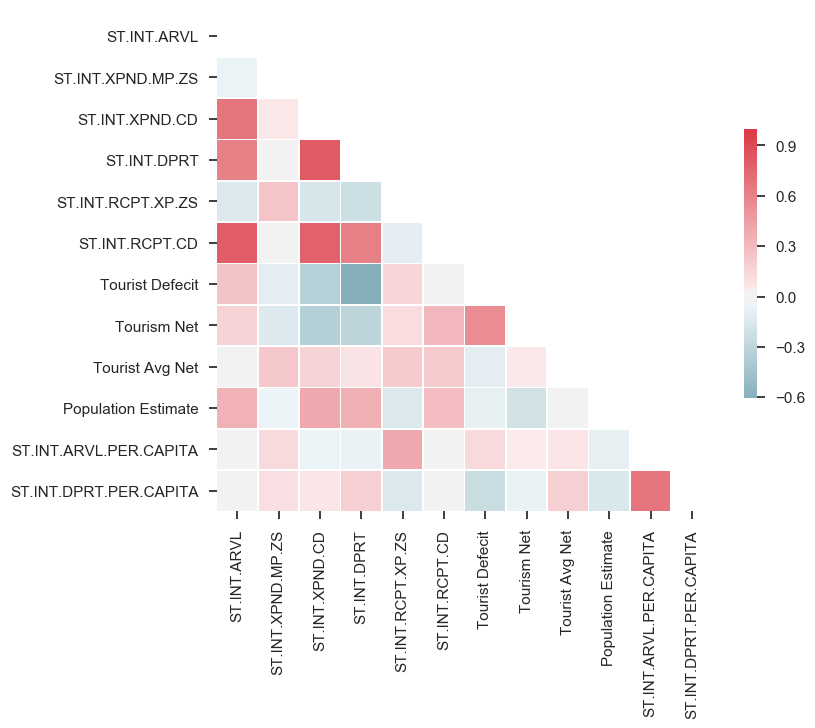

In [15]:
""" Plot a (non-square) correlation heatmap
"""
corr = df_with_pop.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 7))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr,
            mask=mask,
            cmap=cmap,
            vmax=1,
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5})

In [16]:
"""
New profile report suggests that none of the variables 
are highly correlated enough to remove or ignore
"""
profile_two = pandas_profiling.ProfileReport(df_with_pop)
profile_two.to_file("../docs/profile_two.html")

### Descriptive Statistics

In [17]:
desc = df_with_pop.describe()


def pretty_table(var):
    d = desc[var]
    d.index = d.index.str.replace("mean", "x̄").str.replace(
        "count", "𝑛").str.replace("std",
                                  "𝑠").str.replace("25%", "𝑸₁").str.replace(
                                      "50%", "𝑸₂").str.replace("75%", "𝑸₃")
    return d.to_frame()


def plot_dist(x):
    sns.distplot(x[x.notna()])

#### International Arrivals Per Capita
> The mean is slightly higher than 1, 
but this must be highly skewed because
the max value is ~52 and the mean is 
outside the quartile ranges




| {{pretty_table('ST.INT.ARVL.PER.CAPITA')}} | {{plot_dist(df_with_pop['ST.INT.ARVL.PER.CAPITA'])}} |  |
|--------------------------------------------------------------|---------------------------------------------------------------------|---|

#### International Departures Per Capita

| {{pretty_table('ST.INT.DPRT.PER.CAPITA')}} | {{plot_dist(df_with_pop['ST.INT.DPRT.PER.CAPITA'])}} |  |
|--------------------------------------------------------------|---------------------------------------------------------------------|---|

#### Population Estimate

| {{pretty_table('Population Estimate')}} | {{plot_dist(df_with_pop['Population Estimate'])}} |  |
|--------------------------------------------------------------|---------------------------------------------------------------------|---|

#### Tourism Net

| {{pretty_table('Tourism Net')}} | {{plot_dist(df_with_pop['Tourism Net'])}} |  |
|--------------------------------------------------------------|---------------------------------------------------------------------|---|

#### Tourist Defecit

| {{pretty_table('Tourist Defecit')}} | {{plot_dist(df_with_pop['Tourist Defecit'])}} |  |
|--------------------------------------------------------------|---------------------------------------------------------------------|---|

## Save the data

In [18]:
df_with_pop.to_pickle("../data/processed/Tourism.pickle")